<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/jena_climate_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jena Climate Recurent Neural Network - Predict weather



## Import

In [199]:
import math, random, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile

## Parameters

In [200]:
lookback         = 720
step             = 6
train_prop       = 0.8
batch_size       = 32
epochs           = 15
base_dir         = "/content/drive/MyDrive/jena-climate-dataset/"

## Dataset

In [201]:
# ---- Jena Climates 400 000+ records of climate values taken every 10min
# https://www.bgc-jena.mpg.de/wetter/

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [175]:
# ---- Get the columns name as descriptions
#
desc = list(df.columns)

# ---- Count the na values by columns
#
columns_na = df.isna().sum().tolist()

# ---- Show all of that
#
df_desc = pd.DataFrame({'Column':desc, 'Na':columns_na})

display(df_desc.style.set_properties(**{'text-align': 'left'}))

# ---- Extract one row per step
#
df = df.iloc[::step, :]  # Selects every nth row starting from 0


,Column,Na
0,Date Time,0
1,p (mbar),0
2,T (degC),0
3,Tpot (K),0
4,Tdew (degC),0
5,rh (%),0
6,VPmax (mbar),0
7,VPact (mbar),0
8,VPdef (mbar),0
9,sh (g/kg),0


In [176]:
# ---- First of all, we have to sort on the date

df.sort_values(['Date Time'],  inplace=True)
df.reset_index(drop=True, inplace=True)

# -- Remove unused columns

df = df.drop("Date Time", axis=1)

# ---- Nice interpolation for plugging holes

df.interpolate(inplace=True)

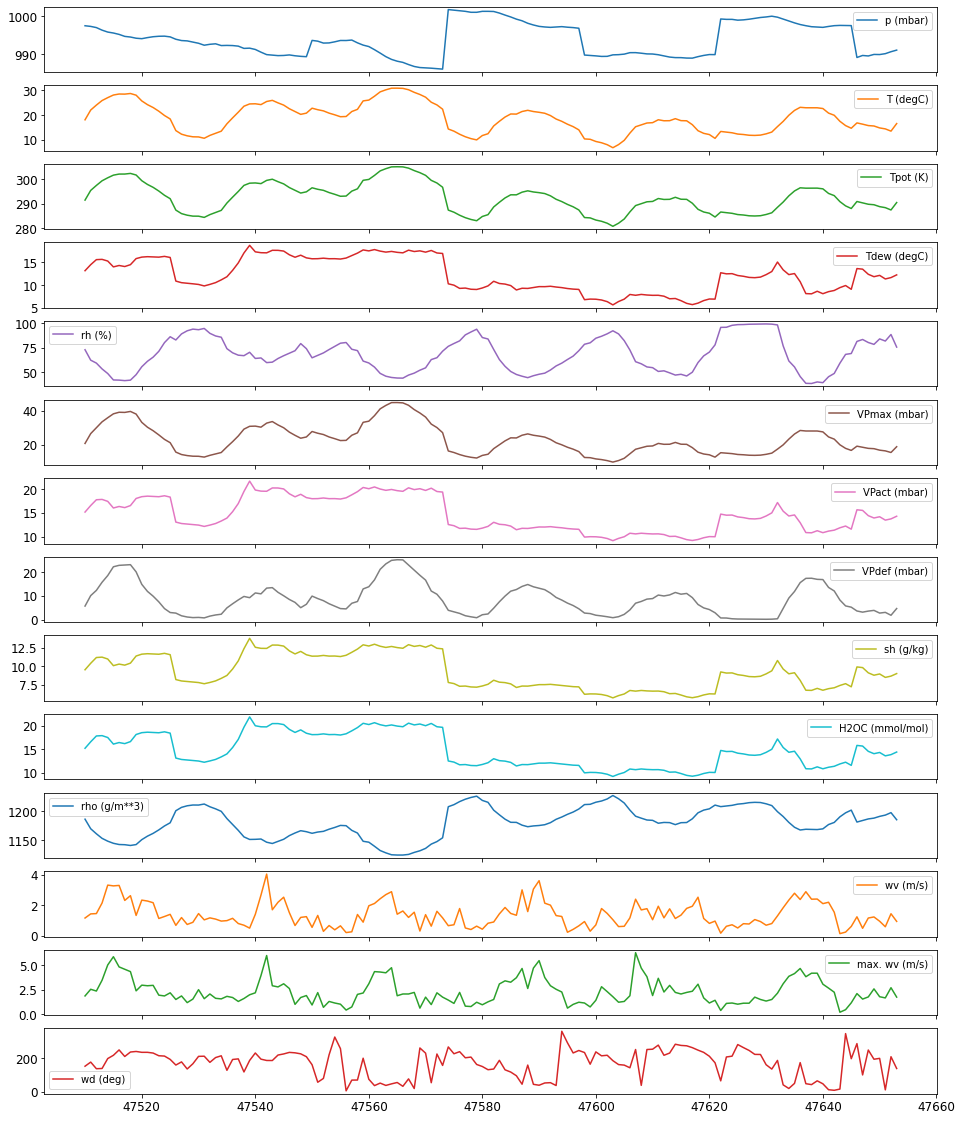

In [177]:
# ---- Plot sample of nth values for each column
#
i = random.randint(0, len(df)-144)
df.iloc[i:i+144].plot(subplots=True, fontsize=12, figsize=(16, 20))
plt.show()

## Preprocessing



In [178]:
def normalise(mean, std, seq):
  return (seq - mean) / std

def denormalize(mean, std, seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq

# ---- Split for test and training set
#
train_split = int(train_prop*len(df))
dataset_train = df.loc[:train_split+1]
dataset_test = df.loc[train_split:]

# ---- Normalize data
#
mean = dataset_train.mean()
std = dataset_train.std()
dataset_train = normalise(mean, std, dataset_train)
dataset_test = normalise(mean, std, dataset_test)

# ---- Show normalized data
#
display(dataset_train.head(10))

# --- Convert to numpy
#
dataset_train = dataset_train.to_numpy()
dataset_test = dataset_test.to_numpy()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.882649,-2.051506,-2.105328,-2.029295,1.048823,-1.311025,-1.519949,-0.776314,-1.521879,-1.524287,2.272690,-0.007486,-0.012362,-0.260648
1,0.880228,-2.004239,-2.057325,-1.940767,1.139884,-1.296844,-1.484151,-0.784485,-1.484279,-1.488918,2.221085,-0.019104,-0.025615,-0.097204
2,0.895964,-2.149584,-2.202504,-2.147333,1.060964,-1.338099,-1.565294,-0.780399,-1.566999,-1.569088,2.381384,-0.019377,-0.027154,-0.191587
3,0.925015,-2.148402,-2.203675,-2.145857,1.060964,-1.336810,-1.565294,-0.780399,-1.563239,-1.569088,2.387866,-0.020607,-0.030112,-0.525380
4,0.946803,-2.194487,-2.251677,-2.228483,0.982044,-1.349703,-1.596320,-0.772228,-1.597080,-1.599741,2.443958,-0.020197,-0.028574,0.333274
5,0.992800,-2.246480,-2.306704,-2.284551,1.006327,-1.362595,-1.615412,-0.776314,-1.615880,-1.618604,2.512017,-0.016644,-0.024195,-0.488548
6,1.038797,-2.237027,-2.299680,-2.260943,1.042752,-1.360016,-1.608252,-0.780399,-1.608360,-1.611530,2.514260,-0.018284,-0.024195,-0.153604
7,1.122318,-2.133040,-2.203675,-2.137004,1.030610,-1.332942,-1.560521,-0.776314,-1.563239,-1.566730,2.425261,0.006591,-0.000529,1.877929
8,1.215523,-2.065686,-2.142793,-2.061756,1.006327,-1.314893,-1.531882,-0.772228,-1.533159,-1.538435,2.378143,-0.011860,-0.021237,0.764902
9,1.278466,-2.014874,-2.097132,-2.024869,0.927408,-1.300711,-1.517563,-0.759971,-1.521879,-1.524287,2.341496,-0.019651,-0.027154,0.691238


## Timeseries Generators

In [179]:
# --- Create data generators
#
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=lookback // step, batch_size=batch_size, )
test_generator = TimeseriesGenerator(dataset_test, dataset_test, length=lookback // step, batch_size=batch_size)

print("Number of training batch : ", len(train_generator))
print("Number of test batch : ", len(test_generator))

Number of training batch :  1749
Number of test batch :  435


## Model

In [180]:
# ---- Model definition - This model should predict the next climate values
# ---- It takes a sequence of nth entries to predict the next one
#
model = keras.models.Sequential()

model.add(keras.layers.GRU(16,
          dropout=0.2,
          recurrent_dropout=0.2,
          input_shape=(None, len(df.columns))))

model.add(keras.layers.Dense(len(df.columns)))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 16)                1536      
                                                                 
 dense_3 (Dense)             (None, 14)                238       
                                                                 
Total params: 1,774
Trainable params: 1,774
Non-trainable params: 0
_________________________________________________________________


## Training

In [181]:
# ---- Training
#
model.compile(optimizer="adam", loss='mae')
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/15
1749/1749 [==============================] - 187s 105ms/step - loss: 0.2627 - val_loss: 0.1633
Epoch 2/15
1749/1749 [==============================] - 175s 100ms/step - loss: 0.1950 - val_loss: 0.1527
Epoch 3/15
1749/1749 [==============================] - 173s 99ms/step - loss: 0.1847 - val_loss: 0.1463
Epoch 4/15
1749/1749 [==============================] - 176s 101ms/step - loss: 0.1777 - val_loss: 0.1426
Epoch 5/15
1749/1749 [==============================] - 180s 103ms/step - loss: 0.1743 - val_loss: 0.1427
Epoch 6/15
1749/1749 [==============================] - 194s 111ms/step - loss: 0.1723 - val_loss: 0.1400
Epoch 7/15
1749/1749 [==============================] - 174s 100ms/step - loss: 0.1711 - val_loss: 0.1379
Epoch 8/15
1749/1749 [==============================] - 173s 99ms/step - loss: 0.1691 - val_loss: 0.1410
Epoch 9/15
1749/1749 [==============================] - 173s 99ms/step - loss: 0.1690 - val_loss: 0.1416
Epoch 10/15
1749/1749 [==========================

## Results

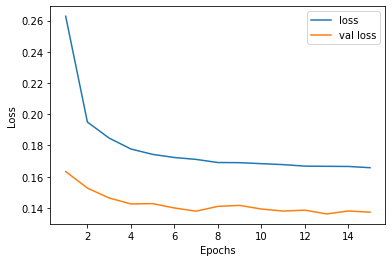

In [186]:
# ---- Log training history
#
epochs_range = range(1,epochs+1)
plt.plot(epochs_range, history.history["loss"], label="loss")
plt.plot(epochs_range, history.history["val_loss"], label="val loss")
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Prediction

In [187]:
# ---- Chaining predictions to get nth future sequences
#

def get_prediction(dataset, model, iterations=4, sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true , pred

In [221]:
# ---- See delta between temperature of a prediction and reality
#

t = lookback // step # number of rows used to determine the new one
i = random.randint(0,len(dataset_test)- t)

# ---- Get prediction for one sequence
#
sequence_pred, sequence_true = get_prediction(dataset_test, model, iterations=1, sequence_len=t)

# --- Get predicted values and reality one
#
sequence_true = sequence_true[-1]
sequence_pred = sequence_pred[0]

# --- Calculate delta between temperature of predicted value and reality
#
delta_deg = abs(sequence_true[1] - sequence_pred[1])

print(f"Predicted : {sequence_pred[1]} °C")
print(f"Reality   : {sequence_true[1]} °C")
print(f'Gap       : {delta_deg} °C')

1/1 [==============================] - 0s 31ms/step
Predicted : 12.21 °C
Reality   : 14.97930908203125 °C
Gap       : 2.769309082031249 °C


1/1 [==============================] - 0s 35ms/step


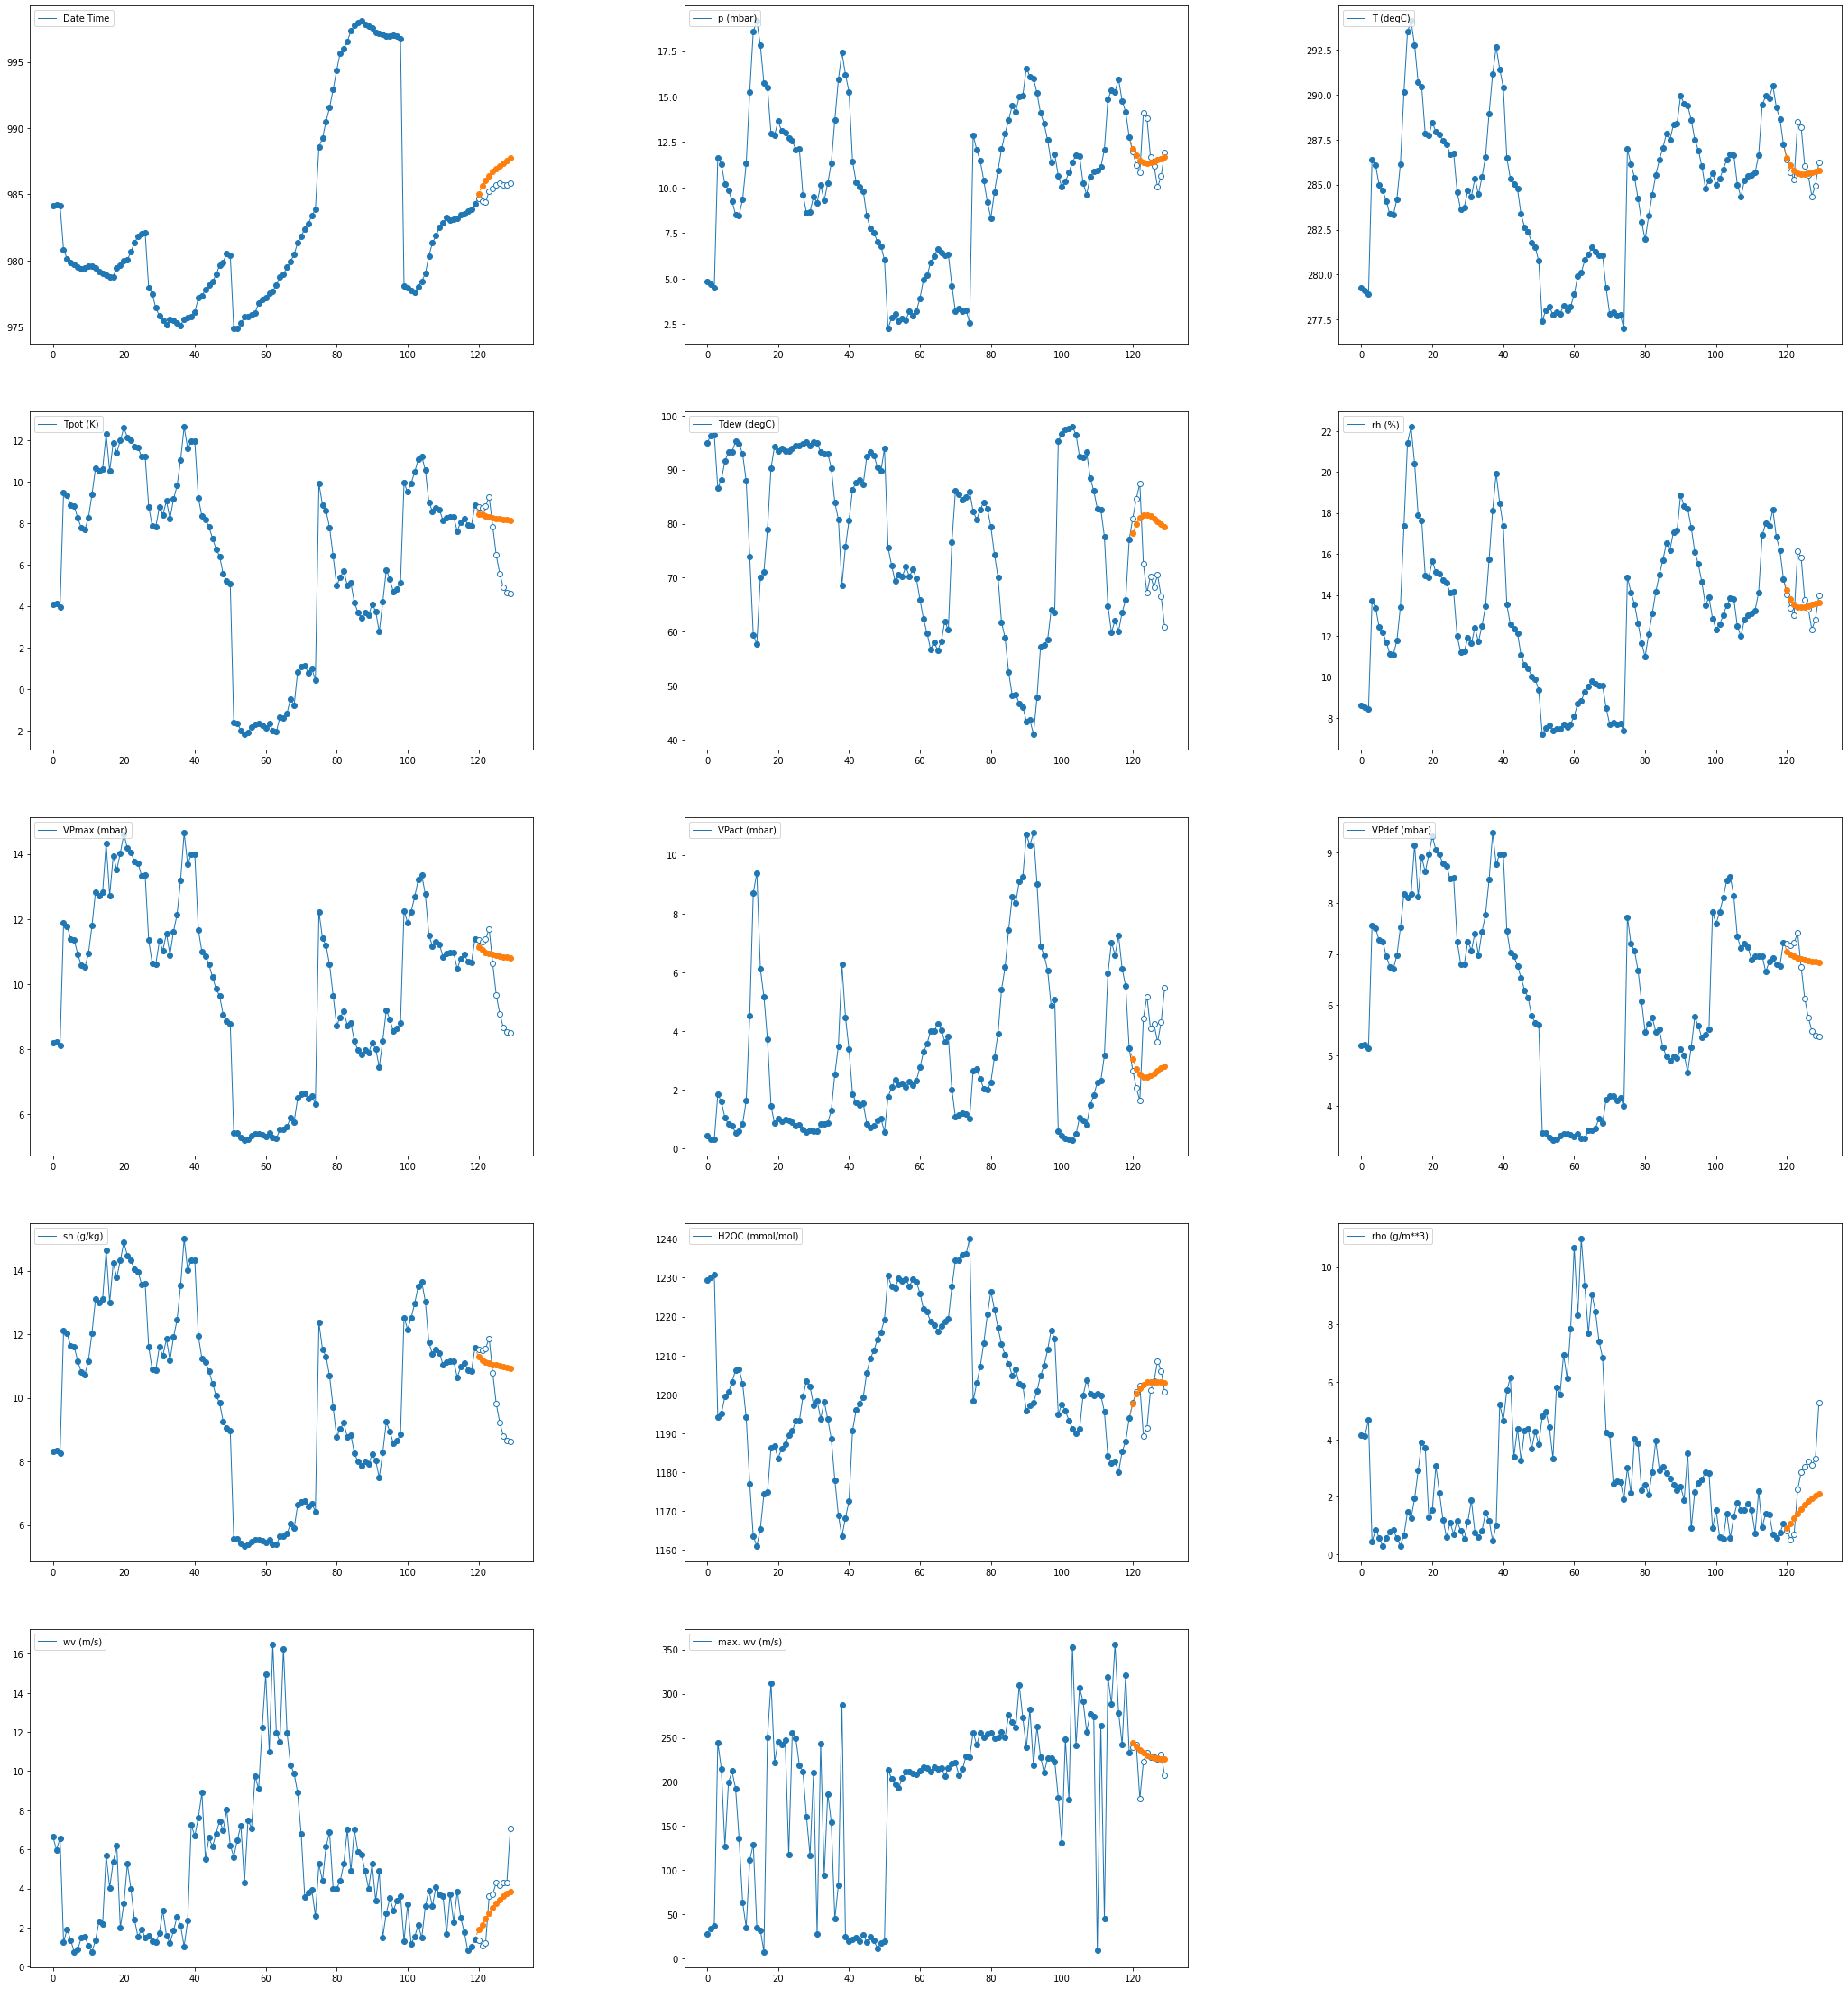

In [222]:
# --- Comparing all predicted values with reality
#

def plot_multivariate_serie(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1
                            , time_dt=1, hide_ticks=False):
    
    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)
    
    t  = np.arange(sequence_len)    
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = math.ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)
        
        # ---- Real sequence without prediction
        #
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # ---- What we expect
        #
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)
        
        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        if hide_ticks:
            ax.set_yticks([])
            ax.set_xticks([])
        
        ax.legend(loc="upper left")
        n+=1
    plt.show()

# ---- If step is 6, iterate 10 times means predict the climate for 10 hours
#
sequence_true, sequence_pred = get_prediction(dataset_test, model, iterations=10, sequence_len=t)

# ---- Gap between prediction and reality for each value
#
plot_multivariate_serie(sequence_true, predictions=sequence_pred, labels=df.columns, width=12, height=8)